#### Normal CNN for the Bird classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
DIR_TRAIN = '../Data/Use/Train/'
DIR_VALID = '../Data/Use/Valid/'

In [4]:
os.listdir(DIR_VALID)

['CASPIAN TERN',
 'D-ARNAUDS BARBET',
 'DARK EYED JUNCO',
 'HOUSE FINCH',
 'OVENBIRD',
 'OYSTER CATCHER',
 'RED TAILED HAWK',
 'SWINHOES PHEASANT',
 'VIOLET GREEN SWALLOW',
 'WOOD DUCK']

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = train_datagen.flow_from_directory(DIR_TRAIN,
                                                target_size=(224,224), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

valid_datagen = valid_datagen.flow_from_directory(DIR_VALID,
                                                target_size=(224,224), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

Found 1000 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [70]:
class ConvNet(tf.keras.Model):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer = [
            tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(3,3)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=50, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation='softmax')
        ]

    def call(self, x):

        for i in self.layer:
            x = i(x)
        return x

In [71]:
net = ConvNet()

net.build(input_shape=(16, 224, 224, 3))
net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
net.summary()

Model: "conv_net_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           multiple                  448       
_________________________________________________________________
average_pooling2d_12 (Averag multiple                  0         
_________________________________________________________________
batch_normalization_28 (Batc multiple                  64        
_________________________________________________________________
conv2d_29 (Conv2D)           multiple                  4640      
_________________________________________________________________
batch_normalization_29 (Batc multiple                  128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_30 (Conv2D)           multiple                  

In [73]:
net.fit(train_datagen, epochs=50, validation_data=valid_datagen)

Epoch 1/50
63/63 [==============================] - 3s 40ms/step - loss: 3.3820 - accuracy: 0.2220 - val_loss: 25.3480 - val_accuracy: 0.1000
Epoch 2/50
63/63 [==============================] - 2s 35ms/step - loss: 1.9899 - accuracy: 0.3120 - val_loss: 32.3200 - val_accuracy: 0.1000
Epoch 3/50
63/63 [==============================] - 2s 35ms/step - loss: 1.9385 - accuracy: 0.3600 - val_loss: 37.3043 - val_accuracy: 0.1000
Epoch 4/50
63/63 [==============================] - 2s 35ms/step - loss: 1.8257 - accuracy: 0.3760 - val_loss: 29.8269 - val_accuracy: 0.1200
Epoch 5/50
63/63 [==============================] - 2s 37ms/step - loss: 1.6715 - accuracy: 0.4410 - val_loss: 9.6472 - val_accuracy: 0.2600
Epoch 6/50
63/63 [==============================] - 2s 36ms/step - loss: 1.5780 - accuracy: 0.4460 - val_loss: 5.5130 - val_accuracy: 0.3600
Epoch 7/50
63/63 [==============================] - 2s 35ms/step - loss: 1.4484 - accuracy: 0.5050 - val_loss: 4.3886 - val_accuracy: 0.3000
Epoch 8/5

#### Predicting a bird

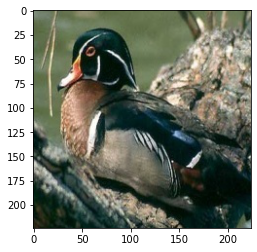

In [86]:
# Load a random image
path = np.random.choice(os.listdir(DIR_VALID))
img = np.random.choice(os.listdir(DIR_VALID + path))
img = Image.open(DIR_VALID + path + '/' + img)

plt.imshow(img)

img = tf.expand_dims(img, 0)
img = tf.cast(img, tf.float32)
img = img / 255.0

In [87]:
preds = net.predict(img)
preds_dict = {}

for n,i in enumerate(preds[0]):
    preds_dict[os.listdir(DIR_VALID)[n]] = i

preds_dict = sorted(preds_dict.items(), key=lambda x: x[1], reverse=True)

print('Actual:', path, '- Predicted:', os.listdir(DIR_VALID)[np.argmax(preds[0])],'\n')

for i in preds_dict:
    print(f'{i[1]:.2f}', i[0])

Actual: WOOD DUCK - Predicted: WOOD DUCK 

0.90 WOOD DUCK
0.08 RED TAILED HAWK
0.02 D-ARNAUDS BARBET
0.00 VIOLET GREEN SWALLOW
0.00 SWINHOES PHEASANT
0.00 DARK EYED JUNCO
0.00 OVENBIRD
0.00 OYSTER CATCHER
0.00 HOUSE FINCH
0.00 CASPIAN TERN
